In [82]:
import os
import torch
from torch import nn, optim
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import cv2
import kagglehub
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Your device is using {device}")

Your device is using cuda


In [57]:
# The dataset is sourced from Kaggle by user 'Aleksei Zagorskii' for face identification.
# Dataset link: https://www.kaggle.com/datasets/juice0lover/face-identification
# Loaded using KaggleHub for easy access: kagglehub.dataset_download('juice0lover/face-identification')
data_path = kagglehub.dataset_download('juice0lover/face-identification')
print('Data source import complete.')
data_path = data_path + "\\faces"


class FaceDataset(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        self.class_to_idx = {}
        self.samples = []
        self._prepare_dataset()

    def _prepare_dataset(self):
        self.class_to_idx = {cls: idx for idx, cls in enumerate(sorted(os.listdir(self.data_path)))}
        self.samples = [
            (os.path.join(self.data_path, cls, img_name), self.class_to_idx[cls])
            for cls in self.class_to_idx
            for img_name in os.listdir(os.path.join(self.data_path, cls))
        ]

    @staticmethod
    def preprocess_image(img, size=(100, 100)):
        img = cv2.resize(img, size)
        img = img.astype(np.float32) / 255.0
        img = torch.from_numpy(img).permute(2, 0, 1)
        return img

    @staticmethod
    def load_image_cv2(img_path):
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Could not read image: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return FaceDataset.preprocess_image(image)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = self.load_image_cv2(img_path)
        return image, label

full_dataset = FaceDataset(data_path)

Data source import complete.


In [113]:
torch.manual_seed(42)
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                         

            nn.Conv2d(64, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),                         

            nn.Conv2d(128, 256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),                         

            nn.Conv2d(256, 512, kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU(),                                  
        )

    def forward(self, x):
        return self.conv_layers(x)


# The CBAM implementation is taken from the GitHub repository by "Jongchan":
# Link: https://github.com/Jongchan/attention-module/blob/master/MODELS/cbam.py
# Paper: "CBAM: Convolutional Block Attention Module" (https://arxiv.org/abs/1807.06521)

class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) 
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

# The ArcFace implementation is taken from the Kaggle notebook by "parthdhameliya77":
# Link: https://www.kaggle.com/code/parthdhameliya77/simple-arcface-implementation-on-mnist-dataset
class ArcFace(nn.Module):
    
    def __init__(self,in_features,out_features,margin = 0.7 ,scale = 64):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.scale = scale
        self.margin = margin
        
        self.weights = nn.Parameter(torch.FloatTensor(out_features,in_features))
        nn.init.xavier_normal_(self.weights)
        
    def forward(self,features,targets):
        cos_theta = F.linear(features,F.normalize(self.weights),bias=None)
        cos_theta = cos_theta.clip(-1+1e-7, 1-1e-7)
        
        arc_cos = torch.acos(cos_theta)
        M = F.one_hot(targets, num_classes = self.out_features) * self.margin
        arc_cos = arc_cos + M
        
        cos_theta_2 = torch.cos(arc_cos)
        logits = cos_theta_2 * self.scale
        return logits




class FaceClassifierNet(nn.Module):
    def __init__(self, embedding_dim=512, num_classes=487):
        super().__init__()

        self.backbone = CNN()
        self.cbam = CBAM(gate_channels=512)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, embedding_dim)
        self.arc_face = ArcFace(in_features=embedding_dim, out_features=num_classes)

    def forward(self, x, targets=None):
        x = self.backbone(x)     
        x = self.cbam(x)        
        x = self.pool(x)       
        x = x.view(x.size(0), -1)  
        x = self.fc(x)           
        x = F.normalize(x)       

        if targets is not None:
            logits = self.arc_face(x, targets)
            return logits
        return x


model = FaceClassifierNet().to(device)

In [114]:
class ModelTrainer:
    def __init__(self, model, dataset, device, batch_size, epochs, train_ratio, val_ratio, test_ratio):
        self.model = model.to(device)
        self.device = device
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        

        self.split_dataset(dataset)
        
        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)
        self.test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

    def split_dataset(self, dataset):
        total_len = len(dataset)
        train_len = int(self.train_ratio * total_len)
        val_len = int(self.val_ratio * total_len)
        test_len = total_len - train_len - val_len
        
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(dataset, [train_len, val_len, test_len])

    def accuracy(self, logits, labels):
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        return accuracy_score(preds, labels)

    def train(self, optimizer, loss_fn):
        for epoch in range(1, self.epochs + 1):
            self.model.train()
            train_loss = 0.0
            train_acc = 0.0
            pbar_train = tqdm(self.train_loader, desc=f"Epoch [{epoch}/{self.epochs}] [TRAIN]")
    
            for i, (images, labels) in enumerate(pbar_train):
                images, labels = images.to(self.device), labels.to(self.device)
                logits = self.model(images, labels)
                loss = loss_fn(logits, labels)
    
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    
                train_loss += loss.item()
                train_acc += self.accuracy(logits, labels)
    
                pbar_train.set_postfix({
                    'loss': f"{train_loss / (i + 1):.6f}",
                    'acc': f"{100*(train_acc / (i + 1)):.2f}%"
                })
    

            self.model.eval()
            val_acc = 0.0
            with torch.no_grad():
                for images, labels in self.val_loader:
                    images, labels = images.to(self.device), labels.to(self.device)
                    logits = self.model(images, labels)
                    val_acc += self.accuracy(logits, labels)
            avg_val_acc = val_acc / len(self.val_loader)
    
            print(f"Validation Accuracy after Epoch {epoch}: {100*avg_val_acc:.2f}%")


    def evaluate(self):
        self.model.eval()
        correct = 0
        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                logits = self.model(images, labels)
                pred = torch.argmax(logits, dim=1)
                correct += (pred == labels).sum().item()

        print(f"Test Accuracy: {100 * correct / len(self.test_dataset):.2f}%")

    def show_random_predictions(self, num_images=4, class_names=None):
        self.model.eval()
        indices = torch.randint(0, len(self.test_dataset), (num_images,))
        images_labels = [self.test_dataset[i] for i in indices]

        fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
        with torch.no_grad():
            for i, (img, true_label) in enumerate(images_labels):
                input_img = img.unsqueeze(0).to(self.device)
                label_tensor = torch.tensor([true_label]).to(self.device)
                logits = self.model(input_img, label_tensor)
                pred = torch.argmax(logits, dim=1).item()

                img_np = img.permute(1, 2, 0).cpu().numpy()
                axs[i].imshow(img_np)
                axs[i].axis('off')

                true_name = f"{true_label}" if class_names is None else class_names[true_label]
                pred_name = f"{pred}" if class_names is None else class_names[pred]
                axs[i].set_title(f"True index: {true_name}\nPred index: {pred_name}")
        
        plt.tight_layout()
        plt.show()

In [115]:
learning_rate, batch_size, epochs, train_ratio, val_ratio, test_ratio = 1e-3, 10, 5, 0.7, 0.15, 0.15
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

trainer = ModelTrainer(
    model=model,
    dataset=full_dataset,
    device=device,
    batch_size=batch_size,
    epochs=epochs,
    train_ratio=train_ratio,
    val_ratio=val_ratio,
    test_ratio=test_ratio
)

trainer.train(optimizer, loss_func)
trainer.evaluate()

Epoch [1/6] [TRAIN]: 100%|████████████████████████████████| 134/134 [00:03<00:00, 42.64it/s, loss=45.946217, acc=0.00%]


Validation Accuracy after Epoch 1: 0.00%


Epoch [2/6] [TRAIN]: 100%|████████████████████████████████| 134/134 [00:02<00:00, 44.75it/s, loss=34.643904, acc=0.00%]


Validation Accuracy after Epoch 2: 0.00%


Epoch [3/6] [TRAIN]: 100%|████████████████████████████████| 134/134 [00:02<00:00, 45.06it/s, loss=19.540507, acc=0.00%]


Validation Accuracy after Epoch 3: 1.38%


Epoch [4/6] [TRAIN]: 100%|████████████████████████████████| 134/134 [00:02<00:00, 45.25it/s, loss=3.437679, acc=69.63%]


Validation Accuracy after Epoch 4: 100.00%


Epoch [5/6] [TRAIN]: 100%|███████████████████████████████| 134/134 [00:02<00:00, 45.33it/s, loss=0.060881, acc=100.00%]


Validation Accuracy after Epoch 5: 100.00%


Epoch [6/6] [TRAIN]: 100%|███████████████████████████████| 134/134 [00:02<00:00, 44.91it/s, loss=0.026600, acc=100.00%]


Validation Accuracy after Epoch 6: 100.00%
Test Accuracy: 100.00%


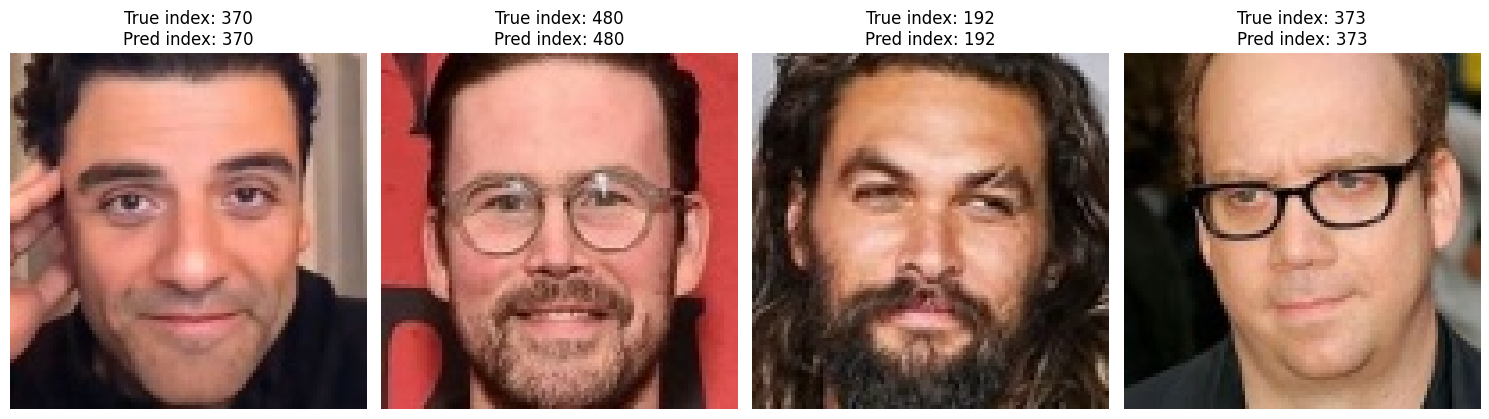

In [116]:
trainer.show_random_predictions()